# gym-jsbsim in Colab
This notebook is a starter to verify the repo loads in Google Colab.

In [ ]:
# Optional: install if running in a fresh Colab session
# !pip -q install gym-jsbsim


In [ ]:
!git clone https://github.com/Gor-Ren/gym-jsbsim.git
%cd gym-jsbsim
!pip -q install -U pip setuptools wheel
!pip -q install -e .
!pip -q install stable-baselines3 shimmy

Cloning into 'gym-jsbsim'...
remote: Enumerating objects: 1427, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1427 (delta 0), reused 0 (delta 0), pack-reused 1425 (from 2)
Receiving objects: 100% (1427/1427), 663.00 KiB | 9.90 MiB/s, done.
Resolving deltas: 100% (1034/1034), done.
/content/gym-jsbsim/gym-jsbsim
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for g

In [ ]:
!python /content/gym-jsbsim/gym_jsbsim/tests/sb3_heading_control_f16.py train --timesteps 1000000

Streaming output truncated to the last 5000 lines.
|    loss                 | -0.0427     |
|    n_updates            | 7490        |
|    policy_gradient_loss | -0.0193     |
|    std                  | 0.217       |
|    value_loss           | 1.29e-05    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 299         |
|    ep_rew_mean          | 147         |
| time/                   |             |
|    fps                  | 603         |
|    iterations           | 751         |
|    time_elapsed         | 1274        |
|    total_timesteps      | 769024      |
| train/                  |             |
|    approx_kl            | 0.015500103 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.35        |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                

In [ ]:
!pip install -q dash dash-extensions fastapi uvicorn pyngrok pandas plotly nest_asyncio

In [ ]:
!pkill -f ngrok || true

^C


In [ ]:
!pkill -f "dash_live.py" || true

^C


In [ ]:
!nohup python /content/gym-jsbsim/gym_jsbsim/realtime/dash_live.py --csv-path /content/gym-jsbsim/models/heading_control_f16/eval_metrics.csv --port 8055 > /tmp/dash.log 2>&1 &

In [ ]:
!python - <<'PY'
from pyngrok import ngrok
ngrok.set_auth_token("")
print("DASH_URL:", ngrok.connect(8055, "http").public_url)


/bin/bash: line 1: warning: here-document at line 1 delimited by end-of-file (wanted `PY')
DASH_URL: https://nonclimactical-suable-yong.ngrok-free.dev


In [ ]:
!python /content/gym-jsbsim/gym_jsbsim/tests/sb3_heading_control_f16.py eval --episodes 5 --deterministic --print-every 25

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:64: PyparsingDeprecationWarning: 'oneOf' deprecated - use 'one_of'
  prop = Group((name + Suppress("=") + comma_separated(value)) | oneOf(_CONSTANTS))
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/usr/local/lib/python3.12/dist-packages/matplotl

In [ ]:
!pip -q install plotly pandas ipywidgets
import os
import math
import time
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, clear_output
import ipywidgets as widgets

CSV_PATH = "/content/gym-jsbsim/models/heading_control_f16/eval_metrics.csv"
REFRESH_SEC = 1.0
MAX_POINTS = 400

stop_btn = widgets.ToggleButton(value=False, description="Stop", button_style="danger")
display(stop_btn)

def f(row, key, default=0.0):
    try:
        return float(row.get(key, default))
    except Exception:
        return default

def integrate_xy(df, dt_sec=0.2):
    x, y = [0.0], [0.0]
    for i in range(1, len(df)):
        vn = float(df.iloc[i]["velocities_v_north_fps"]) * 0.3048
        ve = float(df.iloc[i]["velocities_v_east_fps"]) * 0.3048
        x.append(x[-1] + ve * dt_sec)
        y.append(y[-1] + vn * dt_sec)
    return x, y

def make_attitude(roll_deg, pitch_deg):
    roll = math.radians(roll_deg)
    p_off = max(-0.6, min(0.6, pitch_deg / 30.0))
    dx, dy = math.cos(roll), math.sin(roll)
    x0, y0 = -1.1*dx, p_off - 1.1*dy
    x1, y1 =  1.1*dx, p_off + 1.1*dy

    fig = go.Figure()
    fig.add_shape(type="rect", x0=-1.2, y0=p_off, x1=1.2, y1=1.2, fillcolor="#a8d8ff", line_width=0)
    fig.add_shape(type="rect", x0=-1.2, y0=-1.2, x1=1.2, y1=p_off, fillcolor="#c9a27e", line_width=0)
    fig.add_shape(type="line", x0=x0, y0=y0, x1=x1, y1=y1, line=dict(color="white", width=5))
    fig.add_shape(type="circle", x0=-1.0, y0=-1.0, x1=1.0, y1=1.0, line=dict(color="#2f2f2f", width=3))
    fig.add_trace(go.Scatter(x=[-0.2,0.2], y=[0,0], mode="lines", line=dict(color="#111", width=6), showlegend=False))
    fig.add_trace(go.Scatter(x=[0], y=[0], mode="markers", marker=dict(size=9, color="#111"), showlegend=False))
    fig.update_xaxes(range=[-1.1,1.1], visible=False)
    fig.update_yaxes(range=[-1.1,1.1], visible=False, scaleanchor="x", scaleratio=1)
    fig.update_layout(template="plotly_white", title=f"Attitude Roll={roll_deg:.1f}°  Pitch={pitch_deg:.1f}°", height=320, margin=dict(l=10,r=10,t=40,b=10))
    return fig

while not stop_btn.value:
    clear_output(wait=True)
    display(stop_btn)

    if not os.path.exists(CSV_PATH) or os.path.getsize(CSV_PATH) == 0:
        print("Waiting for:", CSV_PATH)
        time.sleep(REFRESH_SEC)
        continue

    try:
        df = pd.read_csv(CSV_PATH)
    except Exception as e:
        print("CSV read error:", e)
        time.sleep(REFRESH_SEC)
        continue

    if len(df) == 0:
        print("CSV empty")
        time.sleep(REFRESH_SEC)
        continue

    ep = int(df["episode"].max())
    d = df[df["episode"] == ep].tail(MAX_POINTS).copy()
    if len(d) < 2:
        print("Waiting for more episode data...")
        time.sleep(REFRESH_SEC)
        continue

    steps = d["step"].to_list()
    rewards = d["reward"].to_list()
    heading = d["attitude_psi_deg"].to_list()
    target = d["target_track_deg"].to_list()
    altitude = d["position_h_sl_ft"].to_list()
    track_err = d["error_track_error_deg"].to_list()
    roll = d["roll_deg"].to_list()
    pitch = d["pitch_deg"].to_list()

    x_m, y_m = integrate_xy(d)
    z_ft = altitude

    last = d.iloc[-1]
    h = float(last["attitude_psi_deg"])
    t = float(last["target_track_deg"])
    te = float(last["error_track_error_deg"])
    alt = float(last["position_h_sl_ft"])
    r = float(last["roll_deg"])
    p = float(last["pitch_deg"])

    # 3D trajectory
    fig3d = go.Figure()
    fig3d.add_trace(go.Scatter3d(x=x_m, y=y_m, z=z_ft, mode="lines", line=dict(color="#1f77b4", width=6), name="trajectory"))
    fig3d.add_trace(go.Scatter3d(x=[x_m[-1]], y=[y_m[-1]], z=[z_ft[-1]], mode="markers+text",
                                 marker=dict(size=7, color="#d62728"),
                                 text=[f"EP{ep} HDG={h:.1f} R={r:.1f} P={p:.1f}"],
                                 textposition="top center", name="aircraft"))
    fig3d.update_layout(template="plotly_white", title=f"3D Flight Track (EP {ep})",
                        scene=dict(xaxis_title="East (m)", yaxis_title="North (m)", zaxis_title="Altitude (ft)"),
                        height=420, margin=dict(l=10,r=10,t=40,b=10))
    fig3d.show()

    # HUD indicators
    hud = make_subplots(rows=2, cols=3,
                        specs=[[{"type":"indicator"}]*3,
                        [{"type":"indicator"}]*3],
                        vertical_spacing=0.2, horizontal_spacing=0.08)
    hud.add_trace(go.Indicator(mode="number", value=h, title={"text":"Heading"}), row=1, col=1)
    hud.add_trace(go.Indicator(mode="number", value=t, title={"text":"Target"}), row=1, col=2)
    hud.add_trace(go.Indicator(mode="number", value=te, title={"text":"Track Error"}), row=1, col=3)
    hud.add_trace(go.Indicator(mode="number", value=alt, title={"text":"Altitude (ft)"}), row=2, col=1)
    hud.add_trace(go.Indicator(mode="number", value=r, title={"text":"Roll (deg)"}), row=2, col=2)
    hud.add_trace(go.Indicator(mode="number", value=p, title={"text":"Pitch (deg)"}), row=2, col=3)
    hud.update_layout(template="plotly_white", title="HUD", height=320, margin=dict(l=10,r=10,t=40,b=10))
    hud.show()

    # Attitude + timeseries
    att = make_attitude(r, p)
    att.show()

    ts = go.Figure()
    ts.add_scatter(x=steps, y=rewards, mode="lines", name="reward")
    ts.add_scatter(x=steps, y=heading, mode="lines", name="heading_deg")
    ts.add_scatter(x=steps, y=target, mode="lines", name="target_track_deg")
    ts.add_scatter(x=steps, y=altitude, mode="lines", name="altitude_ft")
    ts.add_scatter(x=steps, y=track_err, mode="lines", name="track_error_deg")
    ts.add_scatter(x=steps, y=roll, mode="lines", name="roll_deg", line=dict(dash="dot"))
    ts.add_scatter(x=steps, y=pitch, mode="lines", name="pitch_deg", line=dict(dash="dash"))
    ts.update_layout(template="plotly_white", title=f"Live Timeseries (EP {ep})", height=420, margin=dict(l=10,r=10,t=40,b=10))
    ts.show()

    time.sleep(REFRESH_SEC)

print("Stopped.")

ToggleButton(value=False, button_style='danger', description='Stop')

KeyboardInterrupt: 

In [96]:
!python /content/gym-jsbsim/gym_jsbsim/tests/sb3_heading_control_f16.py train \
    --task turn \
    --timesteps 1000000 \
    --model-dir /content/gym-jsbsim/models/turn_heading_control_f16_v2

Streaming output truncated to the last 5000 lines.
|    loss                 | -0.035      |
|    n_updates            | 7490        |
|    policy_gradient_loss | -0.0244     |
|    std                  | 0.341       |
|    value_loss           | 0.00687     |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 677       |
|    ep_rew_mean          | 213       |
| time/                   |           |
|    fps                  | 608       |
|    iterations           | 751       |
|    time_elapsed         | 1264      |
|    total_timesteps      | 769024    |
| train/                  |           |
|    approx_kl            | 0.0214238 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.391    |
|    explained_variance   | 0.941     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0444   |
|    n_updates   

In [105]:
!python /content/gym-jsbsim/gym_jsbsim/tests/sb3_heading_control_f16.py eval \
    --task turn \
    --model-path /content/gym-jsbsim/models/turn_heading_control_f16_v2/ppo_heading_control_f16.zip \
    --vecnormalize-path /content/gym-jsbsim/models/turn_heading_control_f16_v2/vecnormalize.pkl \
    --csv-path /content/gym-jsbsim/models/eval_outputs/turn_heading_control_f16_v2_eval.csv \
    --episodes 5 --deterministic --print-every 25 --eval-random-target

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:64: PyparsingDeprecationWarning: 'oneOf' deprecated - use 'one_of'
  prop = Group((name + Suppress("=") + comma_separated(value)) | oneOf(_CONSTANTS))
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/usr/local/lib/python3.12/dist-packages/matplotl

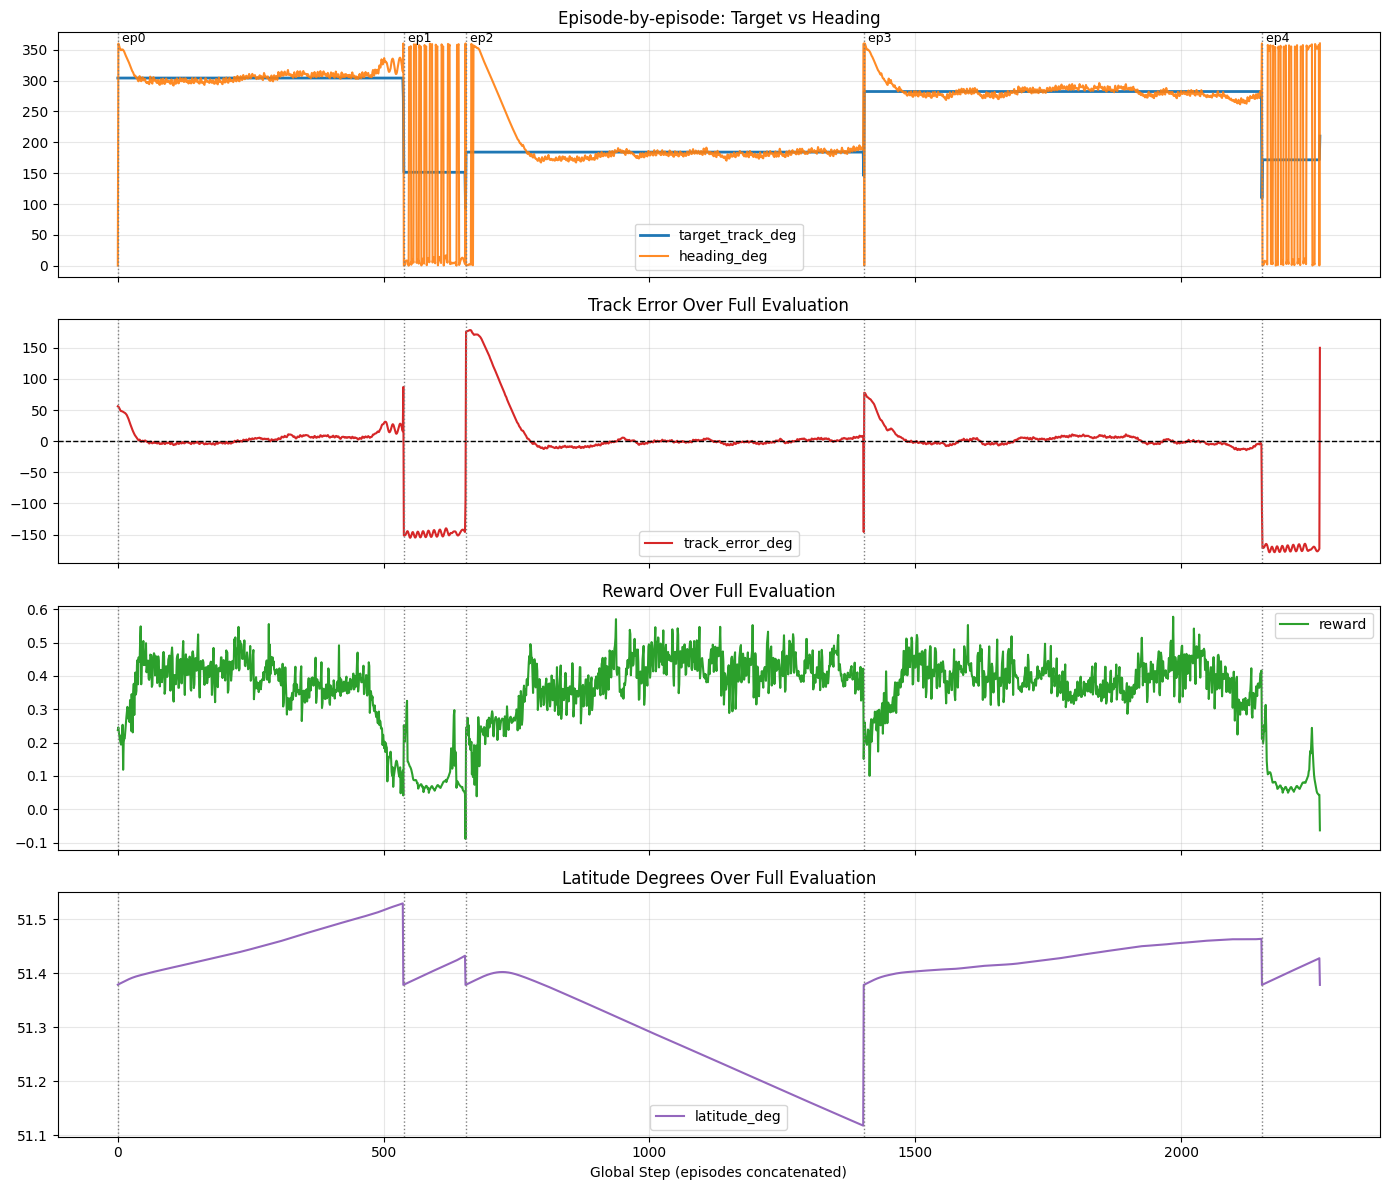

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/gym-jsbsim/models/eval_outputs/turn_heading_control_f16_v2_eval.csv"
df = pd.read_csv(csv_path).sort_values(["episode", "step"]).reset_index(drop=True)

# Global zaman ekseni (episode'ları arka arkaya diz)
df["global_step"] = range(len(df))

# Episode başlangıç indeksleri
starts = df.groupby("episode")["global_step"].min().to_dict()

fig, ax = plt.subplots(4, 1, figsize=(14, 12), sharex=True) # Changed to 4 subplots

# 1) Target vs Heading (istediğin ana grafik)
ax[0].plot(df["global_step"], df["target_track_deg"], label="target_track_deg", linewidth=2)
ax[0].plot(df["global_step"], df["attitude_psi_deg"], label="heading_deg", alpha=0.9)
ax[0].set_title("Episode-by-episode: Target vs Heading")
ax[0].legend()
ax[0].grid(alpha=0.3)

# 2) Track error
ax[1].plot(df["global_step"], df["error_track_error_deg"], color="tab:red", label="track_error_deg")
ax[1].axhline(0, linestyle="--", linewidth=1, color="k")
ax[1].set_title("Track Error Over Full Evaluation")
ax[1].legend()
ax[1].grid(alpha=0.3)

# 3) Reward
ax[2].plot(df["global_step"], df["reward"], color="tab:green", label="reward")
ax[2].set_title("Reward Over Full Evaluation")
ax[2].legend()
ax[2].grid(alpha=0.3)

# 4) Latitude Degrees (New plot)
ax[3].plot(df["global_step"], df["position_lat_geod_deg"], color="tab:purple", label="latitude_deg")
ax[3].set_title("Latitude Degrees Over Full Evaluation")
ax[3].legend()
ax[3].grid(alpha=0.3)
ax[3].set_xlabel("Global Step (episodes concatenated)") # Set xlabel on the last subplot

# Episode sınır çizgileri + etiket
for ep, s in starts.items():
    for a in ax:
        a.axvline(s, color="gray", linestyle=":", linewidth=1)
    ax[0].text(s, ax[0].get_ylim()[1], f" ep{ep}", va="top", fontsize=9)

plt.tight_layout()
plt.show()

In [110]:
print(df.columns)

Index(['episode', 'step', 'reward', 'done', 'position_h_sl_ft',
       'attitude_pitch_rad', 'attitude_roll_rad', 'velocities_u_fps',
       'velocities_v_fps', 'velocities_w_fps', 'velocities_p_rad_sec',
       'velocities_q_rad_sec', 'velocities_r_rad_sec',
       'fcs_left_aileron_pos_norm', 'fcs_right_aileron_pos_norm',
       'fcs_elevator_pos_norm', 'fcs_rudder_pos_norm',
       'error_altitude_error_ft', 'aero_beta_deg', 'error_track_error_deg',
       'info_steps_left', 'attitude_psi_deg', 'position_lat_geod_deg',
       'velocities_h_dot_fps', 'velocities_v_north_fps',
       'velocities_v_east_fps', 'propulsion_engine_thrust_lbs',
       'propulsion_engine_set_running', 'fcs_throttle_cmd_norm',
       'fcs_mixture_cmd_norm', 'fcs_aileron_cmd_norm', 'fcs_elevator_cmd_norm',
       'fcs_rudder_cmd_norm', 'gear_gear_pos_norm', 'target_track_deg',
       'reward_last_agent_reward', 'reward_last_assess_reward', 'roll_deg',
       'pitch_deg', 'global_step'],
      dtype='object')
